In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
import zarr as zr

## Storage

In [3]:
store_path = "./k-ecoli74.zip"
store = zr.storage.ZipStore(store_path, read_only=True)
trace = xr.open_datatree(store, engine="zarr")
store.close()
print(trace)
trace

/opt/anaconda3/envs/ecoli_metabolics/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


<xarray.DataTree>
Group: /
│   Dimensions:  (species: 557)
│   Coordinates:
│     * species  (species) object 4kB '3PG' '6PG' ... 'bm_34_ENZ+His' 'bm_34_ENZ'
│   Attributes:
│       model_file:  /vivarium/vivarium-kecoli/v2Ecoli-metab/src/model/k-ecoli74.xml
└── Group: /simulation
    │   Dimensions:          (perturb_species: 4, conc_factor: 5)
    │   Coordinates:
    │     * perturb_species  (perturb_species) object 32B 'Gluc_e' 'SO4_e' ... 'O2_e'
    │     * conc_factor      (conc_factor) float64 40B 0.3333 0.6667 1.0 1.333 1.667
    │   Attributes:
    │       time_step:  1.0
    └── Group: /simulation/timeseries
            Dimensions:          (perturb_species: 4, conc_factor: 5, time: 301,
                                  species: 557)
            Coordinates:
                time             (perturb_species, conc_factor, time) float64 48kB ...
            Data variables:
                count            (perturb_species, conc_factor, time, species) float64 27MB ...


<xarray.DataTree>
Group: /
│   Dimensions:  (species: 557)
│   Coordinates:
│     * species  (species) object 4kB '3PG' '6PG' ... 'bm_34_ENZ+His' 'bm_34_ENZ'
│   Attributes:
│       model_file:  /vivarium/vivarium-kecoli/v2Ecoli-metab/src/model/k-ecoli74.xml
└── Group: /simulation
    │   Dimensions:          (perturb_species: 4, conc_factor: 5)
    │   Coordinates:
    │     * perturb_species  (perturb_species) object 32B 'Gluc_e' 'SO4_e' ... 'O2_e'
    │     * conc_factor      (conc_factor) float64 40B 0.3333 0.6667 1.0 1.333 1.667
    │   Attributes:
    │       time_step:  1.0
    └── Group: /simulation/timeseries
            Dimensions:          (perturb_species: 4, conc_factor: 5, time: 301,
                                  species: 557)
            Coordinates:
                time             (perturb_species, conc_factor, time) float64 48kB ...
            Data variables:
                count            (perturb_species, conc_factor, time, species) float64 27MB ...

## Visualisation

In [5]:
def plot_sensitivity(trace: xr.DataTree, plot_species=["Pyr", "ATP", "NADH", "Ac_e", "CO2_e"]):
    assert isinstance(trace, xr.DataTree)
    sim = trace["/simulation"]
    plt.rcParams["figure.dpi"] = 120
    fig = plt.figure(constrained_layout=True, figsize=(16, 12))
    plt.suptitle("Sensitivity to perturbations of external substrates", fontsize="x-large")
    subfigs = fig.subfigures(nrows=len(sim.conc_factor), ncols=1)
    for (i, (f, subfig)) in enumerate(zip(sim.conc_factor, subfigs)):
        subfig.supylabel(f"{f:.2f}x concentration", fontsize="large")
        axs = subfig.subplots(nrows=1, ncols=len(sim.perturb_species))
        for (j, (sp_s, ax)) in enumerate(zip(sim.perturb_species, axs)):
            traj = sim["timeseries"].sel(perturb_species=sp_s, conc_factor=f)
            for sp_p in (list(sim.perturb_species.to_numpy()) + plot_species):
                ax.plot(traj["time"].to_numpy(), traj["count"].sel(species=sp_p).to_numpy(),
                        ls='-', marker='o', markevery=20, label=sp_p)
            ax.grid(alpha=.3)
            if i == 0:
                ax.set_title(f"Perturbation: {sp_s.item()}", fontsize="large")
            if i == list(sim.conc_factor).index(1):
                ax.legend(loc="center left", fontsize="small")
            if i == len(sim.conc_factor) - 1:
                ax.set_xlabel("Time (s)")
            if j == 0:
                ax.set_ylabel("Metabolites (mol)")
    plt.show()

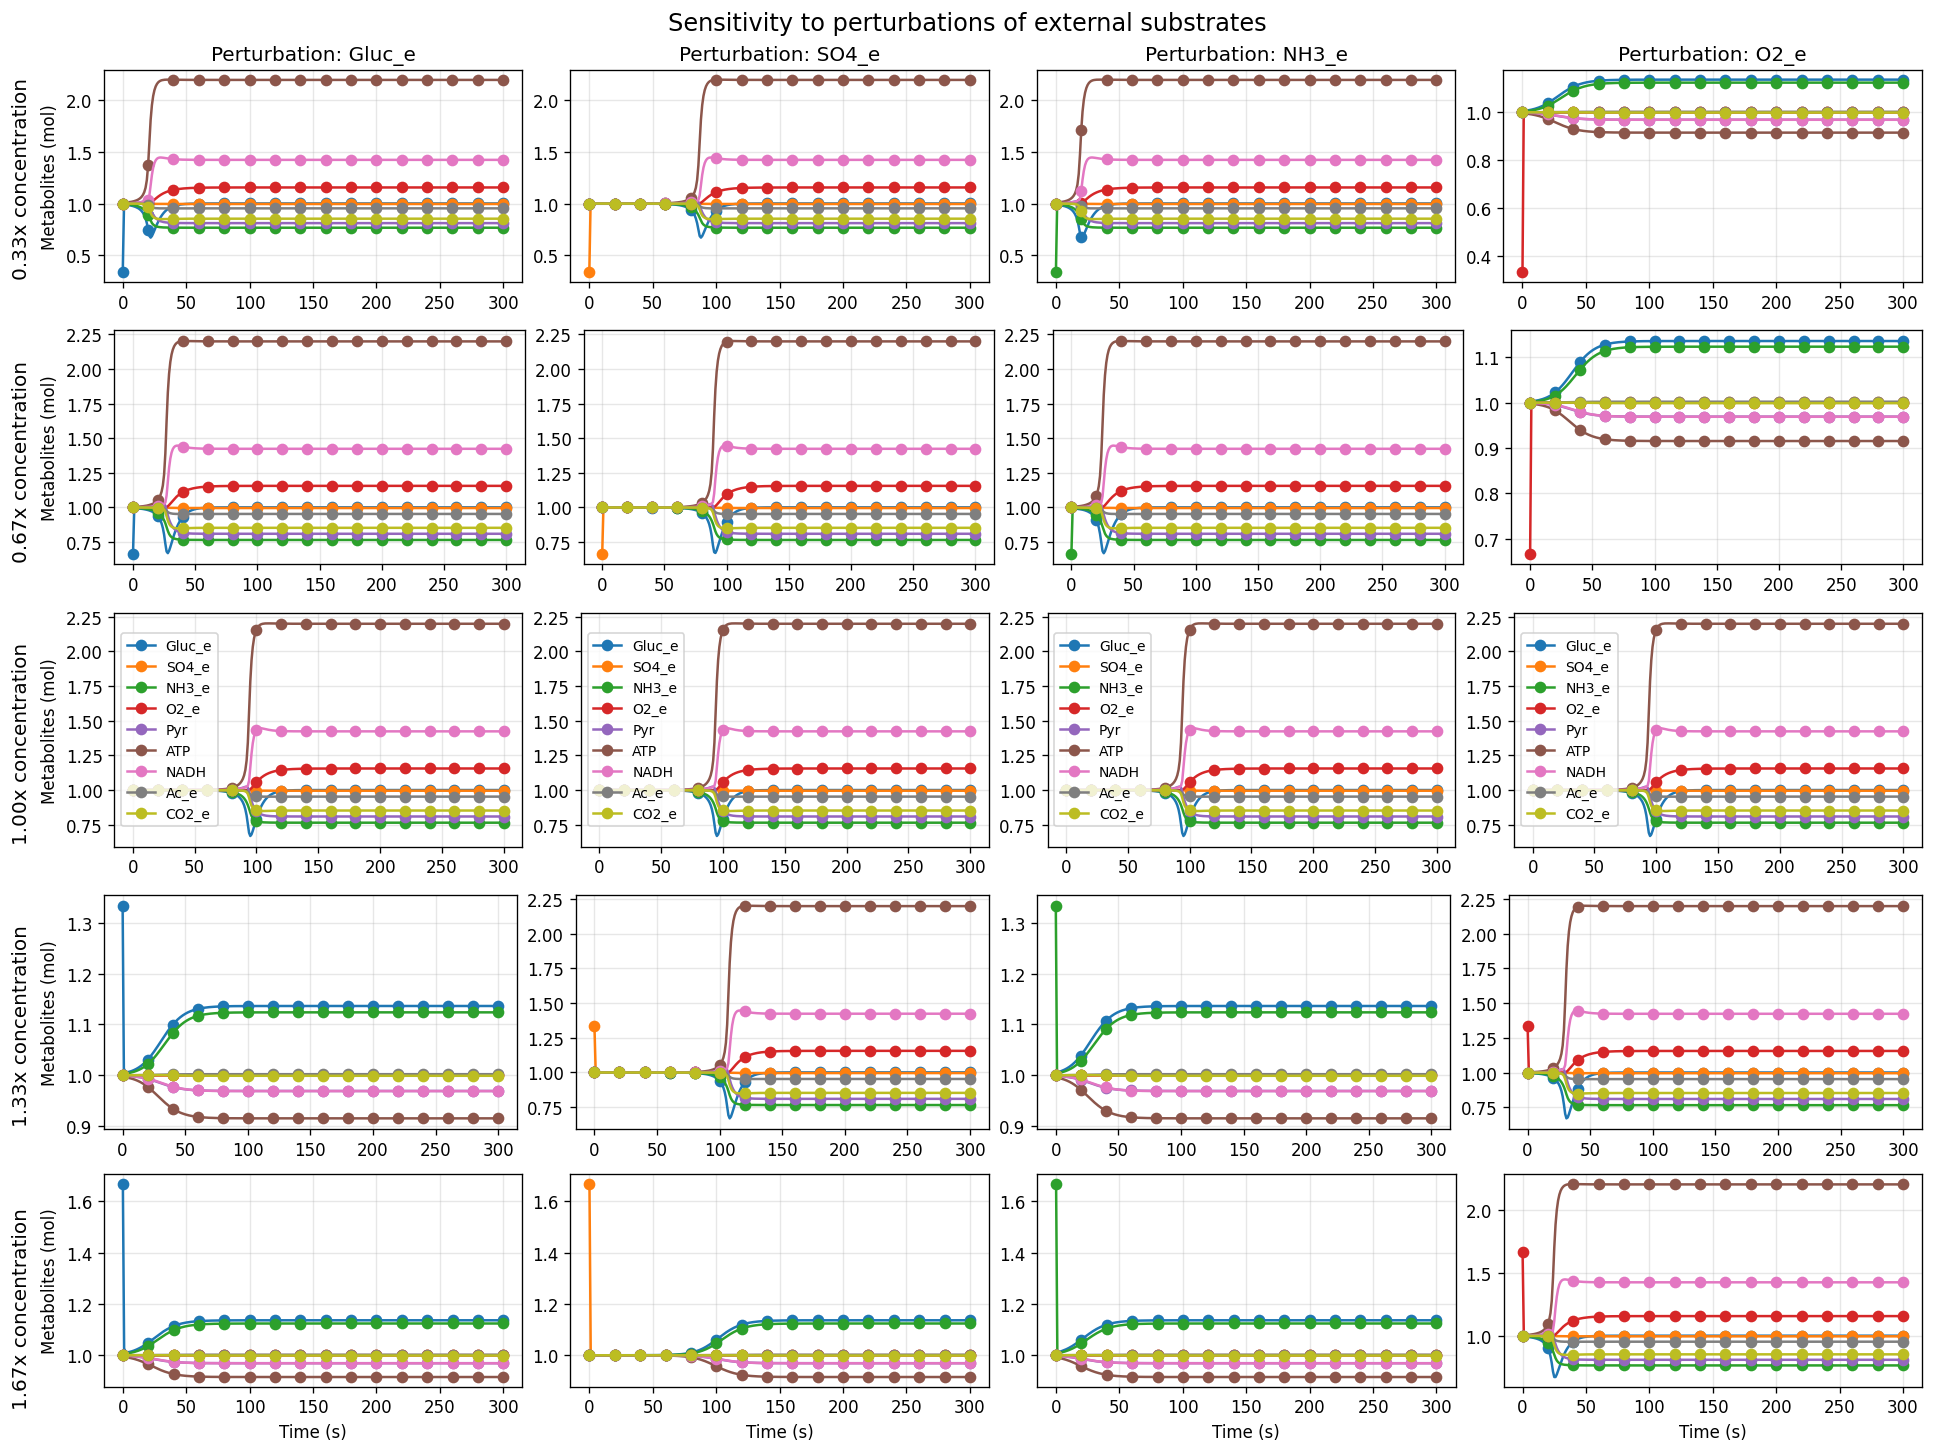

In [6]:
plot_sensitivity(trace)